## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['rise.css',
 'CoronaVirusEcu.ipynb',
 '.gitignore',
 'environment.yml',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'README.md',
 'images',
 '.git',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

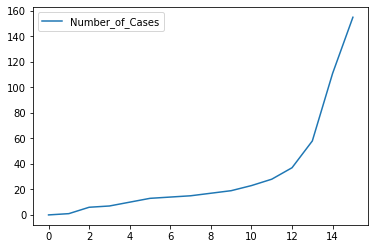

In [4]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = np.array(df['Number_of_Cases'].values.tolist())
y

array([  0,   1,   6,   7,  10,  13,  14,  15,  17,  19,  23,  28,  37,
        58, 111, 155])

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Date'])
x

array([58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [10]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.45057581e+00, 1.05233526e+02, 1.55915121e+07])

In [11]:
(a_, b_, c_) = popt

Matriz Covariante

In [12]:
np.diag(pcov)

array([6.07977997e-01, 1.98254645e+10, 7.98377306e+23])

Error standard para cada parámetro:

In [13]:
np.sqrt(np.diag(pcov))

array([7.79729438e-01, 1.40802928e+05, 8.93519617e+11])

El error del parámetro $c$ es muy elevado:

In [14]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.77972943814088,
 'b_err': 140802.9278413902,
 'c_err': 893519617061.2937}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [15]:
y_pred = logistic_model(x, *popt)
y_pred

array([6.63890577e-02, 9.98430652e-02, 1.50154830e-01, 2.25819118e-01,
       5.10744270e-01, 7.68112615e-01, 1.15517103e+00, 2.61269704e+00,
       5.90924186e+00, 1.33651662e+01, 2.00999778e+01, 3.02285069e+01,
       4.54608629e+01, 6.83688758e+01, 1.02820304e+02, 1.54631810e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

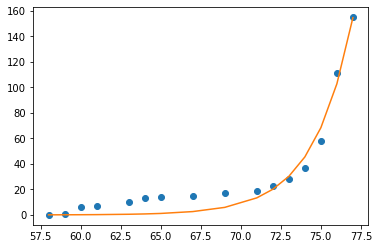

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [17]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en millones):

In [18]:
results['total_infected']/1e6

15.591512116535618

In [19]:
results['total_infected']-errors_dict['c_err']

-893504025549.1771

El pico de infección se obtiene para el día:

In [20]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

151

La fecha esperada para el pico de infección es:

In [21]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 31


Cuántos casos se espera para hoy?

In [22]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-22 00:00:00 corresponde al día 81 con respecto al 01/01/20
Predicción del número de infecciones: 790.9822238290434


Para la fecha de máxima infecciones, cuántas infecciones?

In [23]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)/1e6
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 15.591511995729325


## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

In [24]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 4, 13)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)/1e6

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

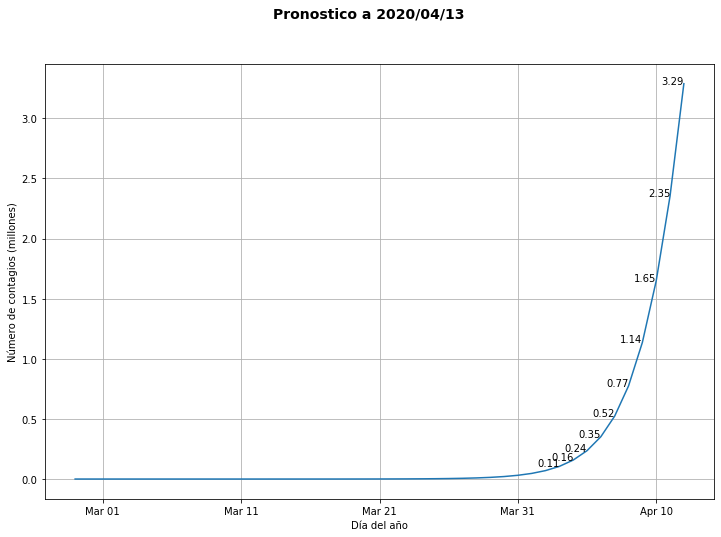

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Pronostico a 2020/04/13', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
for xi,yi in zip(x_pronos,y_pronos):
    if yi>0.1:
        ax.text(xi-0.8, yi, "%.2f" %yi, ha='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios (millones)')
ax.grid(True)
fig.savefig('images/proyectionApril13.png')

<center>
<img src="images/proyectionApril13.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Si consideramos que la población del Ecuador es de 17 millones (https://countrymeters.info/es/Ecuador), 15 millones de contagiados, en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.

* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 


In [26]:
population = 17368483
rate = results['total_infected']/population*100.0
print(rate)
days_remaining = sol-df['Date'].iloc[0]
print(days_remaining)

89.76899201004267
93


### Artificial Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [28]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [29]:
x_stats = df["Date"].describe()
x_stats

count    16.000000
mean     67.750000
std       6.454972
min      58.000000
25%      62.500000
50%      68.000000
75%      73.250000
max      77.000000
Name: Date, dtype: float64

In [30]:
y_stats = df["Number_of_Cases"].describe()
y_stats

count     16.000000
mean      32.125000
std       42.665951
min        0.000000
25%        9.250000
50%       16.000000
75%       30.250000
max      155.000000
Name: Number_of_Cases, dtype: float64

In [31]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.51046351, -1.35554417, -1.20062484, -1.0457055 , -0.73586684,
       -0.5809475 , -0.42602817, -0.1161895 ,  0.19364917,  0.50348784,
        0.65840717,  0.8133265 ,  0.96824584,  1.12316517,  1.2780845 ,
        1.43300384])

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

Epoch 1/100
14/14 [==============================] - 1s 46ms/step - loss: 3128.1566 - mae: 36.6037 - mse: 3128.1567
Epoch 2/100
14/14 [==============================] - 0s 12ms/step - loss: 3118.0351 - mae: 36.5144 - mse: 3118.0352
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 3108.1429 - mae: 36.4055 - mse: 3108.1428
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 3095.1329 - mae: 36.2593 - mse: 3095.1328
Epoch 5/100
14/14 [==============================] - 0s 11ms/step - loss: 3080.2179 - mae: 36.0600 - mse: 3080.2180
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 3057.2249 - mae: 35.8194 - mse: 3057.2249
Epoch 7/100
14/14 [==============================] - 0s 12ms/step - loss: 3028.1557 - mae: 35.5493 - mse: 3028.1558
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 2999.7878 - mae: 35.1137 - mse: 2999.7878
Epoch 9/100
14/14 [==============================] - 0s 14ms/step - loss: 2

14/14 [==============================] - 0s 11ms/step - loss: 571.6707 - mae: 17.2303 - mse: 571.6708
Epoch 73/100
14/14 [==============================] - 0s 8ms/step - loss: 630.8957 - mae: 17.9340 - mse: 630.8956
Epoch 74/100
14/14 [==============================] - 0s 5ms/step - loss: 479.9403 - mae: 16.0965 - mse: 479.9404
Epoch 75/100
14/14 [==============================] - 0s 11ms/step - loss: 500.6250 - mae: 16.9171 - mse: 500.6250
Epoch 76/100
14/14 [==============================] - 0s 10ms/step - loss: 585.4303 - mae: 17.8802 - mse: 585.4303
Epoch 77/100
14/14 [==============================] - 0s 14ms/step - loss: 564.2683 - mae: 17.8167 - mse: 564.2682
Epoch 78/100
14/14 [==============================] - 0s 10ms/step - loss: 539.4135 - mae: 17.7770 - mse: 539.4135
Epoch 79/100
14/14 [==============================] - 0s 10ms/step - loss: 575.6711 - mae: 16.7708 - mse: 575.6711
Epoch 80/100
14/14 [==============================] - 0s 15ms/step - loss: 530.6753 - mae: 17.2

Epoch 43/100
14/14 [==============================] - 0s 7ms/step - loss: 539.3432 - mae: 17.6398 - mse: 539.3432
Epoch 44/100
14/14 [==============================] - 0s 8ms/step - loss: 638.6349 - mae: 18.6174 - mse: 638.6349
Epoch 45/100
14/14 [==============================] - 0s 9ms/step - loss: 667.5075 - mae: 19.6227 - mse: 667.5074
Epoch 46/100
14/14 [==============================] - 0s 8ms/step - loss: 579.8013 - mae: 18.3785 - mse: 579.8013
Epoch 47/100
14/14 [==============================] - 0s 10ms/step - loss: 601.8826 - mae: 18.8837 - mse: 601.8825
Epoch 48/100
14/14 [==============================] - 0s 9ms/step - loss: 497.2712 - mae: 17.0780 - mse: 497.2712
Epoch 49/100
14/14 [==============================] - 0s 8ms/step - loss: 613.1957 - mae: 18.4669 - mse: 613.1957
Epoch 50/100
14/14 [==============================] - 0s 5ms/step - loss: 605.3997 - mae: 19.0108 - mse: 605.3998
Epoch 51/100
14/14 [==============================] - 0s 7ms/step - loss: 559.2031 - ma

14/14 [==============================] - 0s 8ms/step - loss: 2637.4068 - mae: 31.3526 - mse: 2637.4067
Epoch 15/100
14/14 [==============================] - 0s 11ms/step - loss: 2547.0379 - mae: 30.5624 - mse: 2547.0378
Epoch 16/100
14/14 [==============================] - 0s 9ms/step - loss: 2426.9972 - mae: 29.5766 - mse: 2426.9973
Epoch 17/100
14/14 [==============================] - 0s 8ms/step - loss: 2315.3017 - mae: 28.6425 - mse: 2315.3015
Epoch 18/100
14/14 [==============================] - 0s 6ms/step - loss: 2190.0673 - mae: 27.6119 - mse: 2190.0671
Epoch 19/100
14/14 [==============================] - 0s 10ms/step - loss: 2059.3107 - mae: 26.4851 - mse: 2059.3108
Epoch 20/100
14/14 [==============================] - 0s 11ms/step - loss: 1910.6363 - mae: 24.9245 - mse: 1910.6361
Epoch 21/100
14/14 [==============================] - 0s 5ms/step - loss: 1718.0406 - mae: 23.3799 - mse: 1718.0406
Epoch 22/100
14/14 [==============================] - 0s 8ms/step - loss: 1600.810

14/14 [==============================] - 0s 7ms/step - loss: 517.8420 - mae: 16.4923 - mse: 517.8419
Epoch 86/100
14/14 [==============================] - 0s 10ms/step - loss: 504.5960 - mae: 16.2838 - mse: 504.5960
Epoch 87/100
14/14 [==============================] - 0s 15ms/step - loss: 564.3063 - mae: 17.2822 - mse: 564.3063
Epoch 88/100
14/14 [==============================] - 0s 17ms/step - loss: 560.5180 - mae: 17.2232 - mse: 560.5180
Epoch 89/100
14/14 [==============================] - 0s 8ms/step - loss: 584.0880 - mae: 17.3180 - mse: 584.0880
Epoch 90/100
14/14 [==============================] - 0s 12ms/step - loss: 539.1904 - mae: 16.1023 - mse: 539.1904
Epoch 91/100
14/14 [==============================] - 0s 12ms/step - loss: 567.1150 - mae: 16.6150 - mse: 567.1151
Epoch 92/100
14/14 [==============================] - 0s 11ms/step - loss: 479.7484 - mae: 15.8804 - mse: 479.7484
Epoch 93/100
14/14 [==============================] - 0s 6ms/step - loss: 612.4418 - mae: 17.23

14/14 [==============================] - 0s 10ms/step - loss: 630.4553 - mae: 18.3124 - mse: 630.4554
Epoch 56/100
14/14 [==============================] - 0s 8ms/step - loss: 541.7175 - mae: 16.8848 - mse: 541.7175
Epoch 57/100
14/14 [==============================] - 0s 7ms/step - loss: 550.6115 - mae: 17.9463 - mse: 550.6115
Epoch 58/100
14/14 [==============================] - 0s 9ms/step - loss: 593.5362 - mae: 17.5739 - mse: 593.5363
Epoch 59/100
14/14 [==============================] - 0s 9ms/step - loss: 583.1043 - mae: 17.1076 - mse: 583.1043
Epoch 60/100
14/14 [==============================] - 0s 7ms/step - loss: 516.2583 - mae: 16.4472 - mse: 516.2582
Epoch 61/100
14/14 [==============================] - 0s 10ms/step - loss: 536.4821 - mae: 17.0177 - mse: 536.4821
Epoch 62/100
14/14 [==============================] - 0s 8ms/step - loss: 525.0913 - mae: 16.9028 - mse: 525.0912
Epoch 63/100
14/14 [==============================] - 0s 9ms/step - loss: 525.2765 - mae: 16.4213 -

14/14 [==============================] - 0s 10ms/step - loss: 1469.6013 - mae: 21.1756 - mse: 1469.6013
Epoch 26/100
14/14 [==============================] - 0s 13ms/step - loss: 1339.9821 - mae: 19.9750 - mse: 1339.9822
Epoch 27/100
14/14 [==============================] - 0s 24ms/step - loss: 1215.3971 - mae: 18.4869 - mse: 1215.3971
Epoch 28/100
14/14 [==============================] - 0s 13ms/step - loss: 1106.4154 - mae: 17.7835 - mse: 1106.4153
Epoch 29/100
14/14 [==============================] - 0s 15ms/step - loss: 1011.3213 - mae: 17.2845 - mse: 1011.3213
Epoch 30/100
14/14 [==============================] - 0s 9ms/step - loss: 952.1704 - mae: 17.5028 - mse: 952.1703
Epoch 31/100
14/14 [==============================] - 0s 9ms/step - loss: 836.4804 - mae: 17.2788 - mse: 836.4804
Epoch 32/100
14/14 [==============================] - 0s 10ms/step - loss: 723.7690 - mae: 15.9342 - mse: 723.7690
Epoch 33/100
14/14 [==============================] - 0s 8ms/step - loss: 705.6050 - 

14/14 [==============================] - 0s 20ms/step - loss: 474.5180 - mae: 15.0422 - mse: 474.5181
Epoch 97/100
14/14 [==============================] - 0s 8ms/step - loss: 568.2131 - mae: 16.8332 - mse: 568.2131
Epoch 98/100
14/14 [==============================] - 0s 10ms/step - loss: 553.4812 - mae: 15.9521 - mse: 553.4813
Epoch 99/100
14/14 [==============================] - 0s 12ms/step - loss: 610.7280 - mae: 16.4913 - mse: 610.7280
Epoch 100/100
2/2 [==============================] - 0s 61ms/step
Epoch 1/100
14/14 [==============================] - 1s 49ms/step - loss: 3033.2069 - mae: 33.0455 - mse: 3033.2070
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 3023.2222 - mae: 32.9545 - mse: 3023.2222
Epoch 3/100
14/14 [==============================] - 0s 12ms/step - loss: 3016.1885 - mae: 32.8591 - mse: 3016.1887
Epoch 4/100
14/14 [==============================] - 0s 22ms/step - loss: 3005.7194 - mae: 32.7550 - mse: 3005.7192
Epoch 5/100
14/14 [=====

14/14 [==============================] - 0s 17ms/step - loss: 482.1320 - mae: 14.9177 - mse: 482.1320
Epoch 67/100
14/14 [==============================] - 0s 13ms/step - loss: 369.6130 - mae: 13.5334 - mse: 369.6131
Epoch 68/100
14/14 [==============================] - 0s 7ms/step - loss: 416.2993 - mae: 14.3493 - mse: 416.2993
Epoch 69/100
14/14 [==============================] - 0s 10ms/step - loss: 400.0276 - mae: 14.1926 - mse: 400.0276
Epoch 70/100
14/14 [==============================] - 0s 9ms/step - loss: 444.6099 - mae: 14.5124 - mse: 444.6099
Epoch 71/100
14/14 [==============================] - 0s 14ms/step - loss: 332.9855 - mae: 12.9310 - mse: 332.9855
Epoch 72/100
14/14 [==============================] - 0s 9ms/step - loss: 409.4929 - mae: 14.0475 - mse: 409.4930
Epoch 73/100
14/14 [==============================] - 0s 13ms/step - loss: 485.3152 - mae: 15.0495 - mse: 485.3152
Epoch 74/100
14/14 [==============================] - 0s 13ms/step - loss: 489.7193 - mae: 15.14

15/15 [==============================] - 0s 6ms/step - loss: 521.4407 - mae: 15.2622 - mse: 521.4407
Epoch 37/100
15/15 [==============================] - 0s 10ms/step - loss: 535.7899 - mae: 16.3788 - mse: 535.7899
Epoch 38/100
15/15 [==============================] - 0s 7ms/step - loss: 446.6080 - mae: 15.0173 - mse: 446.6080
Epoch 39/100
15/15 [==============================] - 0s 7ms/step - loss: 553.5710 - mae: 15.8417 - mse: 553.5710
Epoch 40/100
15/15 [==============================] - 0s 6ms/step - loss: 466.5805 - mae: 15.6340 - mse: 466.5805
Epoch 41/100
15/15 [==============================] - 0s 6ms/step - loss: 515.0631 - mae: 16.0816 - mse: 515.0631
Epoch 42/100
15/15 [==============================] - 0s 5ms/step - loss: 541.6371 - mae: 16.1291 - mse: 541.6371
Epoch 43/100
15/15 [==============================] - 0s 5ms/step - loss: 453.9424 - mae: 15.3922 - mse: 453.9424
Epoch 44/100
15/15 [==============================] - 0s 8ms/step - loss: 422.5734 - mae: 14.9792 - 

15/15 [==============================] - 0s 8ms/step - loss: 2620.6088 - mae: 29.6323 - mse: 2620.6089
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 2595.0093 - mae: 29.4398 - mse: 2595.0093
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 2566.0657 - mae: 29.1765 - mse: 2566.0659
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: 2543.4999 - mae: 28.9144 - mse: 2543.4998
Epoch 11/100
15/15 [==============================] - 0s 15ms/step - loss: 2509.9353 - mae: 28.7218 - mse: 2509.9353
Epoch 12/100
15/15 [==============================] - 0s 11ms/step - loss: 2463.6599 - mae: 28.2713 - mse: 2463.6599
Epoch 13/100
15/15 [==============================] - 0s 13ms/step - loss: 2423.2057 - mae: 27.9893 - mse: 2423.2058
Epoch 14/100
15/15 [==============================] - 0s 11ms/step - loss: 2362.9485 - mae: 27.4215 - mse: 2362.9485
Epoch 15/100
15/15 [==============================] - 0s 9ms/step - loss: 2315.063

15/15 [==============================] - 0s 14ms/step - loss: 463.9042 - mae: 15.2935 - mse: 463.9042
Epoch 79/100
15/15 [==============================] - 0s 10ms/step - loss: 553.3159 - mae: 16.4974 - mse: 553.3159
Epoch 80/100
15/15 [==============================] - 0s 13ms/step - loss: 458.6472 - mae: 15.0837 - mse: 458.6472
Epoch 81/100
15/15 [==============================] - 0s 15ms/step - loss: 429.0158 - mae: 14.8891 - mse: 429.0157
Epoch 82/100
15/15 [==============================] - 0s 9ms/step - loss: 506.3997 - mae: 15.4463 - mse: 506.3997
Epoch 83/100
15/15 [==============================] - 0s 10ms/step - loss: 531.3403 - mae: 16.1624 - mse: 531.3403
Epoch 84/100
15/15 [==============================] - 0s 12ms/step - loss: 431.2170 - mae: 14.6329 - mse: 431.2170
Epoch 85/100
15/15 [==============================] - 0s 11ms/step - loss: 466.5739 - mae: 14.9527 - mse: 466.5739
Epoch 86/100
15/15 [==============================] - 0s 13ms/step - loss: 565.1391 - mae: 16.

15/15 [==============================] - 0s 15ms/step - loss: 502.7704 - mae: 14.3244 - mse: 502.7704
Epoch 49/100
15/15 [==============================] - 0s 10ms/step - loss: 507.0511 - mae: 14.8562 - mse: 507.0511
Epoch 50/100
15/15 [==============================] - 0s 15ms/step - loss: 510.1354 - mae: 13.7510 - mse: 510.1354
Epoch 51/100
15/15 [==============================] - 0s 13ms/step - loss: 472.7832 - mae: 13.4438 - mse: 472.7833
Epoch 52/100
15/15 [==============================] - 0s 11ms/step - loss: 488.1281 - mae: 14.6727 - mse: 488.1281
Epoch 53/100
15/15 [==============================] - 0s 9ms/step - loss: 551.1593 - mae: 15.0752 - mse: 551.1593
Epoch 54/100
15/15 [==============================] - 0s 11ms/step - loss: 512.7846 - mae: 14.6037 - mse: 512.7846
Epoch 55/100
15/15 [==============================] - 0s 7ms/step - loss: 484.1088 - mae: 14.1664 - mse: 484.1088
Epoch 56/100
15/15 [==============================] - 0s 14ms/step - loss: 486.1812 - mae: 14.6

15/15 [==============================] - 0s 17ms/step - loss: 809.9782 - mae: 17.9829 - mse: 809.9783
Epoch 19/100
15/15 [==============================] - 0s 14ms/step - loss: 762.1237 - mae: 17.1675 - mse: 762.1238
Epoch 20/100
15/15 [==============================] - 0s 17ms/step - loss: 694.0415 - mae: 15.9815 - mse: 694.0414
Epoch 21/100
15/15 [==============================] - 0s 17ms/step - loss: 638.8453 - mae: 15.0438 - mse: 638.8453
Epoch 22/100
15/15 [==============================] - 0s 14ms/step - loss: 569.9431 - mae: 13.9018 - mse: 569.9431
Epoch 23/100
15/15 [==============================] - 0s 12ms/step - loss: 513.6700 - mae: 12.8699 - mse: 513.6700
Epoch 24/100
15/15 [==============================] - 0s 9ms/step - loss: 478.5565 - mae: 12.2017 - mse: 478.5565
Epoch 25/100
15/15 [==============================] - 0s 19ms/step - loss: 398.9582 - mae: 10.9727 - mse: 398.9582
Epoch 26/100
15/15 [==============================] - 0s 16ms/step - loss: 348.3686 - mae: 10.

Epoch 90/100
15/15 [==============================] - 0s 7ms/step - loss: 196.2111 - mae: 9.0293 - mse: 196.2110
Epoch 91/100
15/15 [==============================] - 0s 5ms/step - loss: 181.2554 - mae: 8.6439 - mse: 181.2554
Epoch 92/100
15/15 [==============================] - 0s 8ms/step - loss: 215.2926 - mae: 9.6139 - mse: 215.2926
Epoch 93/100
15/15 [==============================] - 0s 8ms/step - loss: 198.7268 - mae: 9.1417 - mse: 198.7268
Epoch 94/100
15/15 [==============================] - 0s 9ms/step - loss: 206.2529 - mae: 9.0911 - mse: 206.2529
Epoch 95/100
15/15 [==============================] - 0s 5ms/step - loss: 183.3390 - mae: 8.4115 - mse: 183.3390
Epoch 96/100
15/15 [==============================] - 0s 7ms/step - loss: 195.8997 - mae: 8.5428 - mse: 195.8997
Epoch 97/100
15/15 [==============================] - 0s 8ms/step - loss: 205.3245 - mae: 9.3307 - mse: 205.3245
Epoch 98/100
15/15 [==============================] - 0s 9ms/step - loss: 206.1855 - mae: 9.1778

In [33]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[ 0.00408983],
       [ 0.00367037],
       [ 0.00325089],
       [ 0.00283143],
       [ 0.00199248],
       [ 0.00157301],
       [ 0.00115354],
       [ 0.0003146 ],
       [-0.00107845],
       [-0.00280396],
       [-0.00366672],
       [-0.00452948],
       [-0.00539223],
       [-0.00625499],
       [-0.00711775],
       [-0.0079805 ]], dtype=float32)

In [34]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [35]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
16/16 [==============================] - 1s 38ms/step - loss: 2739.2874 - mae: 32.1284 - mse: 2739.2874
Epoch 2/1500
16/16 [==============================] - 0s 4ms/step - loss: 2733.5955 - mae: 32.0756 - mse: 2733.5955
Epoch 3/1500
16/16 [==============================] - 0s 2ms/step - loss: 2730.5874 - mae: 32.0466 - mse: 2730.5874
Epoch 4/1500
16/16 [==============================] - 0s 2ms/step - loss: 2727.1177 - mae: 32.0164 - mse: 2727.1177
Epoch 5/1500
16/16 [==============================] - 0s 2ms/step - loss: 2723.5430 - mae: 31.9813 - mse: 2723.5430
Epoch 6/1500
16/16 [==============================] - 0s 1ms/step - loss: 2718.9529 - mae: 31.9371 - mse: 2718.9529
Epoch 7/1500
16/16 [==============================] - 0s 2ms/step - loss: 2716.4683 - mae: 31.8996 - mse: 2716.4683
Epoch 8/1500
16/16 [==============================] - 0s 2ms/step - loss: 2710.2029 - mae: 31.8414 - mse: 2710.2029
Epoch 9/1500
16/16 [==============================] - 0s 2ms/step - los

Epoch 72/1500
16/16 [==============================] - 0s 4ms/step - loss: 483.1399 - mae: 15.3935 - mse: 483.1399
Epoch 73/1500
16/16 [==============================] - 0s 3ms/step - loss: 568.7906 - mae: 16.3200 - mse: 568.7906
Epoch 74/1500
16/16 [==============================] - 0s 4ms/step - loss: 507.4197 - mae: 16.1470 - mse: 507.4197
Epoch 75/1500
16/16 [==============================] - 0s 4ms/step - loss: 499.4385 - mae: 16.1549 - mse: 499.4385
Epoch 76/1500
16/16 [==============================] - 0s 2ms/step - loss: 506.7358 - mae: 15.8663 - mse: 506.7358
Epoch 77/1500
16/16 [==============================] - 0s 3ms/step - loss: 551.1430 - mae: 16.8430 - mse: 551.1430
Epoch 78/1500
16/16 [==============================] - 0s 3ms/step - loss: 407.4921 - mae: 14.6708 - mse: 407.4921
Epoch 79/1500
16/16 [==============================] - 0s 3ms/step - loss: 498.8833 - mae: 16.3905 - mse: 498.8833
Epoch 80/1500
16/16 [==============================] - 0s 2ms/step - loss: 495.5

Epoch 143/1500
16/16 [==============================] - 0s 4ms/step - loss: 450.4780 - mae: 14.6445 - mse: 450.4780
Epoch 144/1500
16/16 [==============================] - 0s 3ms/step - loss: 396.2399 - mae: 13.8632 - mse: 396.2399
Epoch 145/1500
16/16 [==============================] - 0s 3ms/step - loss: 403.3513 - mae: 13.6862 - mse: 403.3513
Epoch 146/1500
16/16 [==============================] - 0s 4ms/step - loss: 481.8699 - mae: 15.1001 - mse: 481.8699
Epoch 147/1500
16/16 [==============================] - 0s 3ms/step - loss: 396.9697 - mae: 13.8190 - mse: 396.9697
Epoch 148/1500
16/16 [==============================] - 0s 3ms/step - loss: 477.6032 - mae: 14.5155 - mse: 477.6032
Epoch 149/1500
16/16 [==============================] - 0s 3ms/step - loss: 404.9972 - mae: 13.9553 - mse: 404.9972
Epoch 150/1500
16/16 [==============================] - 0s 4ms/step - loss: 435.1673 - mae: 14.2617 - mse: 435.1673
Epoch 151/1500
16/16 [==============================] - 0s 2ms/step - lo

Epoch 214/1500
16/16 [==============================] - 0s 2ms/step - loss: 406.1498 - mae: 13.2605 - mse: 406.1498
Epoch 215/1500
16/16 [==============================] - 0s 3ms/step - loss: 353.3501 - mae: 12.1214 - mse: 353.3501
Epoch 216/1500
16/16 [==============================] - 0s 2ms/step - loss: 293.5865 - mae: 11.0714 - mse: 293.5865
Epoch 217/1500
16/16 [==============================] - 0s 2ms/step - loss: 363.1191 - mae: 12.0603 - mse: 363.1191
Epoch 218/1500
16/16 [==============================] - 0s 3ms/step - loss: 312.3660 - mae: 11.3779 - mse: 312.3660
Epoch 219/1500
16/16 [==============================] - 0s 3ms/step - loss: 338.0298 - mae: 11.8105 - mse: 338.0298
Epoch 220/1500
16/16 [==============================] - 0s 3ms/step - loss: 355.0340 - mae: 12.1189 - mse: 355.0340
Epoch 221/1500
16/16 [==============================] - 0s 3ms/step - loss: 335.3522 - mae: 11.9466 - mse: 335.3522
Epoch 222/1500
16/16 [==============================] - 0s 3ms/step - lo

Epoch 285/1500
16/16 [==============================] - 0s 4ms/step - loss: 260.7484 - mae: 10.1559 - mse: 260.7484
Epoch 286/1500
16/16 [==============================] - 0s 7ms/step - loss: 236.6662 - mae: 9.4293 - mse: 236.6662
Epoch 287/1500
16/16 [==============================] - 0s 7ms/step - loss: 250.7514 - mae: 10.2052 - mse: 250.7514
Epoch 288/1500
16/16 [==============================] - 0s 5ms/step - loss: 222.1378 - mae: 9.3350 - mse: 222.1378
Epoch 289/1500
16/16 [==============================] - 0s 3ms/step - loss: 233.9345 - mae: 10.0373 - mse: 233.9345
Epoch 290/1500
16/16 [==============================] - 0s 5ms/step - loss: 270.0684 - mae: 10.1053 - mse: 270.0684
Epoch 291/1500
16/16 [==============================] - 0s 5ms/step - loss: 211.8321 - mae: 9.6399 - mse: 211.8321
Epoch 292/1500
16/16 [==============================] - 0s 5ms/step - loss: 210.2086 - mae: 9.3717 - mse: 210.2086
Epoch 293/1500
16/16 [==============================] - 0s 5ms/step - loss: 

Epoch 357/1500
16/16 [==============================] - 0s 7ms/step - loss: 112.5023 - mae: 6.0016 - mse: 112.5023
Epoch 358/1500
16/16 [==============================] - 0s 4ms/step - loss: 132.9779 - mae: 6.9163 - mse: 132.9779
Epoch 359/1500
16/16 [==============================] - 0s 3ms/step - loss: 94.5175 - mae: 6.2428 - mse: 94.5175
Epoch 360/1500
16/16 [==============================] - 0s 3ms/step - loss: 99.8242 - mae: 6.3367 - mse: 99.8242
Epoch 361/1500
16/16 [==============================] - 0s 5ms/step - loss: 97.1198 - mae: 6.3876 - mse: 97.1198
Epoch 362/1500
16/16 [==============================] - 0s 5ms/step - loss: 95.2723 - mae: 5.9963 - mse: 95.2723
Epoch 363/1500
16/16 [==============================] - 0s 6ms/step - loss: 83.4048 - mae: 5.5445 - mse: 83.4048
Epoch 364/1500
16/16 [==============================] - 0s 5ms/step - loss: 90.6516 - mae: 5.5735 - mse: 90.6516
Epoch 365/1500
16/16 [==============================] - 0s 4ms/step - loss: 127.4819 - mae: 

Epoch 430/1500
16/16 [==============================] - 0s 3ms/step - loss: 21.8822 - mae: 3.3262 - mse: 21.8822
Epoch 431/1500
16/16 [==============================] - 0s 2ms/step - loss: 30.2763 - mae: 3.4281 - mse: 30.2763
Epoch 432/1500
16/16 [==============================] - 0s 4ms/step - loss: 26.5649 - mae: 3.4576 - mse: 26.5649
Epoch 433/1500
16/16 [==============================] - 0s 3ms/step - loss: 32.4496 - mae: 3.4133 - mse: 32.4496
Epoch 434/1500
16/16 [==============================] - 0s 3ms/step - loss: 37.1848 - mae: 3.7201 - mse: 37.1848
Epoch 435/1500
16/16 [==============================] - 0s 5ms/step - loss: 21.1721 - mae: 2.7008 - mse: 21.1721
Epoch 436/1500
16/16 [==============================] - 0s 4ms/step - loss: 26.3775 - mae: 2.8066 - mse: 26.3775
Epoch 437/1500
16/16 [==============================] - 0s 6ms/step - loss: 15.5344 - mae: 2.3152 - mse: 15.5344
Epoch 438/1500
16/16 [==============================] - 0s 2ms/step - loss: 17.1655 - mae: 2.527

Epoch 503/1500
16/16 [==============================] - 0s 4ms/step - loss: 17.0598 - mae: 2.5888 - mse: 17.0598
Epoch 504/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.5560 - mae: 2.0246 - mse: 7.5560
Epoch 505/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.0399 - mae: 2.0720 - mse: 7.0399
Epoch 506/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.2674 - mae: 1.9753 - mse: 8.2674
Epoch 507/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.7030 - mae: 1.4301 - mse: 4.7030
Epoch 508/1500
16/16 [==============================] - 0s 5ms/step - loss: 5.6637 - mae: 1.6722 - mse: 5.6637
Epoch 509/1500
16/16 [==============================] - 0s 3ms/step - loss: 6.8230 - mae: 1.8119 - mse: 6.8230
Epoch 510/1500
16/16 [==============================] - 0s 2ms/step - loss: 14.7964 - mae: 2.2637 - mse: 14.7964
Epoch 511/1500
16/16 [==============================] - 0s 2ms/step - loss: 9.0149 - mae: 1.5334 - mse: 9.01

Epoch 577/1500
16/16 [==============================] - 0s 5ms/step - loss: 18.5881 - mae: 2.6779 - mse: 18.5881
Epoch 578/1500
16/16 [==============================] - 0s 4ms/step - loss: 20.4952 - mae: 2.4409 - mse: 20.4952
Epoch 579/1500
16/16 [==============================] - 0s 5ms/step - loss: 6.8838 - mae: 1.8132 - mse: 6.8838
Epoch 580/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.3085 - mae: 1.7167 - mse: 5.3085
Epoch 581/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.6480 - mae: 1.4511 - mse: 3.6480
Epoch 582/1500
16/16 [==============================] - 0s 3ms/step - loss: 10.5196 - mae: 1.6435 - mse: 10.5196
Epoch 583/1500
16/16 [==============================] - 0s 5ms/step - loss: 4.4534 - mae: 1.5614 - mse: 4.4534
Epoch 584/1500
16/16 [==============================] - 0s 4ms/step - loss: 21.5616 - mae: 2.0954 - mse: 21.5616
Epoch 585/1500
16/16 [==============================] - 0s 2ms/step - loss: 18.3350 - mae: 2.6828 - mse:

Epoch 651/1500
16/16 [==============================] - 0s 3ms/step - loss: 24.1389 - mae: 2.6130 - mse: 24.1389
Epoch 652/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.6533 - mae: 1.3762 - mse: 4.6533
Epoch 653/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.8874 - mae: 2.1967 - mse: 9.8874
Epoch 654/1500
16/16 [==============================] - 0s 5ms/step - loss: 17.5587 - mae: 2.3644 - mse: 17.5587
Epoch 655/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.8837 - mae: 1.9848 - mse: 6.8837
Epoch 656/1500
16/16 [==============================] - 0s 3ms/step - loss: 16.5387 - mae: 2.0217 - mse: 16.5387
Epoch 657/1500
16/16 [==============================] - 0s 3ms/step - loss: 18.7796 - mae: 2.5391 - mse: 18.7796
Epoch 658/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.2994 - mae: 1.2533 - mse: 2.2994
Epoch 659/1500
16/16 [==============================] - 0s 4ms/step - loss: 1.4966 - mae: 0.9592 - mse: 

Epoch 725/1500
16/16 [==============================] - 0s 4ms/step - loss: 31.7230 - mae: 2.5195 - mse: 31.7230
Epoch 726/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.3487 - mae: 1.7527 - mse: 5.3487
Epoch 727/1500
16/16 [==============================] - 0s 5ms/step - loss: 4.7935 - mae: 1.5448 - mse: 4.7935
Epoch 728/1500
16/16 [==============================] - 0s 6ms/step - loss: 7.9407 - mae: 1.8943 - mse: 7.9407
Epoch 729/1500
16/16 [==============================] - 0s 3ms/step - loss: 22.5637 - mae: 3.3623 - mse: 22.5637
Epoch 730/1500
16/16 [==============================] - 0s 6ms/step - loss: 21.4485 - mae: 3.0622 - mse: 21.4485
Epoch 731/1500
16/16 [==============================] - 0s 5ms/step - loss: 19.4370 - mae: 2.8665 - mse: 19.4370
Epoch 732/1500
16/16 [==============================] - 0s 3ms/step - loss: 8.5654 - mae: 1.8738 - mse: 8.5654
Epoch 733/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.5723 - mae: 1.5946 - mse: 

Epoch 799/1500
16/16 [==============================] - 0s 2ms/step - loss: 17.9545 - mae: 2.2899 - mse: 17.9545
Epoch 800/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.8246 - mae: 2.1728 - mse: 9.8246
Epoch 801/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.6042 - mae: 2.1346 - mse: 7.6042
Epoch 802/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.0377 - mae: 1.8760 - mse: 6.0377
Epoch 803/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.4753 - mae: 1.9432 - mse: 6.4753
Epoch 804/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.0710 - mae: 1.5230 - mse: 5.0710
Epoch 805/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.6622 - mae: 1.3091 - mse: 5.6622
Epoch 806/1500
16/16 [==============================] - 0s 5ms/step - loss: 10.1802 - mae: 1.9912 - mse: 10.1802
Epoch 807/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.1745 - mae: 1.5121 - mse: 7.17

Epoch 873/1500
16/16 [==============================] - 0s 4ms/step - loss: 20.8915 - mae: 3.6383 - mse: 20.8915
Epoch 874/1500
16/16 [==============================] - 0s 3ms/step - loss: 11.6053 - mae: 1.9869 - mse: 11.6053
Epoch 875/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.6279 - mae: 1.6320 - mse: 4.6279
Epoch 876/1500
16/16 [==============================] - 0s 2ms/step - loss: 5.7654 - mae: 1.6740 - mse: 5.7654
Epoch 877/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.3836 - mae: 1.5022 - mse: 3.3836
Epoch 878/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.8013 - mae: 1.9122 - mse: 7.8013
Epoch 879/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.3214 - mae: 1.5833 - mse: 7.3214
Epoch 880/1500
16/16 [==============================] - 0s 4ms/step - loss: 13.4209 - mae: 1.8881 - mse: 13.4209
Epoch 881/1500
16/16 [==============================] - 0s 6ms/step - loss: 5.1475 - mae: 1.4333 - mse: 5.

Epoch 947/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.2501 - mae: 0.9476 - mse: 2.2501
Epoch 948/1500
16/16 [==============================] - 0s 2ms/step - loss: 7.4275 - mae: 1.5776 - mse: 7.4275
Epoch 949/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.7904 - mae: 1.7381 - mse: 8.7904
Epoch 950/1500
16/16 [==============================] - 0s 6ms/step - loss: 2.7738 - mae: 1.2090 - mse: 2.7738
Epoch 951/1500
16/16 [==============================] - 0s 3ms/step - loss: 29.2848 - mae: 2.4414 - mse: 29.2848
Epoch 952/1500
16/16 [==============================] - 0s 2ms/step - loss: 48.4361 - mae: 3.5891 - mse: 48.4361
Epoch 953/1500
16/16 [==============================] - 0s 3ms/step - loss: 29.5570 - mae: 3.4696 - mse: 29.5570
Epoch 954/1500
16/16 [==============================] - 0s 2ms/step - loss: 5.1885 - mae: 1.8251 - mse: 5.1885
Epoch 955/1500
16/16 [==============================] - 0s 3ms/step - loss: 3.1936 - mae: 1.2644 - mse: 3.

Epoch 1021/1500
16/16 [==============================] - 0s 5ms/step - loss: 25.5753 - mae: 2.9801 - mse: 25.5753
Epoch 1022/1500
16/16 [==============================] - 0s 2ms/step - loss: 25.6698 - mae: 2.8356 - mse: 25.6698
Epoch 1023/1500
16/16 [==============================] - 0s 4ms/step - loss: 15.0864 - mae: 2.8833 - mse: 15.0864
Epoch 1024/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.9566 - mae: 2.3709 - mse: 7.9566
Epoch 1025/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.0539 - mae: 2.0091 - mse: 7.0539
Epoch 1026/1500
16/16 [==============================] - 0s 3ms/step - loss: 9.2628 - mae: 1.9095 - mse: 9.2628
Epoch 1027/1500
16/16 [==============================] - 0s 3ms/step - loss: 13.6882 - mae: 2.1403 - mse: 13.6882
Epoch 1028/1500
16/16 [==============================] - 0s 5ms/step - loss: 4.2871 - mae: 1.5185 - mse: 4.2871
Epoch 1029/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.4138 - mae: 1.191

Epoch 1094/1500
16/16 [==============================] - 0s 5ms/step - loss: 9.1845 - mae: 1.5309 - mse: 9.1845
Epoch 1095/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.9305 - mae: 1.5091 - mse: 7.9305
Epoch 1096/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.5126 - mae: 1.4359 - mse: 4.5126
Epoch 1097/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.9674 - mae: 1.3718 - mse: 3.9674
Epoch 1098/1500
16/16 [==============================] - 0s 5ms/step - loss: 4.7490 - mae: 1.3732 - mse: 4.7490
Epoch 1099/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.1097 - mae: 1.4169 - mse: 3.1097
Epoch 1100/1500
16/16 [==============================] - 0s 5ms/step - loss: 11.2855 - mae: 2.0694 - mse: 11.2855
Epoch 1101/1500
16/16 [==============================] - 0s 4ms/step - loss: 13.2218 - mae: 2.4351 - mse: 13.2218
Epoch 1102/1500
16/16 [==============================] - 0s 5ms/step - loss: 12.0131 - mae: 2.2738 -

Epoch 1167/1500
16/16 [==============================] - 0s 5ms/step - loss: 4.8355 - mae: 1.2926 - mse: 4.8355
Epoch 1168/1500
16/16 [==============================] - 0s 4ms/step - loss: 0.9561 - mae: 0.6983 - mse: 0.9561
Epoch 1169/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.8923 - mae: 1.7539 - mse: 8.8923
Epoch 1170/1500
16/16 [==============================] - 0s 4ms/step - loss: 33.7048 - mae: 3.1807 - mse: 33.7048
Epoch 1171/1500
16/16 [==============================] - 0s 3ms/step - loss: 36.2359 - mae: 3.4512 - mse: 36.2359
Epoch 1172/1500
16/16 [==============================] - 0s 4ms/step - loss: 16.3351 - mae: 2.7722 - mse: 16.3351
Epoch 1173/1500
16/16 [==============================] - 0s 5ms/step - loss: 21.0477 - mae: 2.9929 - mse: 21.0477
Epoch 1174/1500
16/16 [==============================] - 0s 3ms/step - loss: 15.7368 - mae: 2.8483 - mse: 15.7368
Epoch 1175/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.4443 - mae: 1.6

Epoch 1240/1500
16/16 [==============================] - 0s 2ms/step - loss: 5.6401 - mae: 1.3838 - mse: 5.6401
Epoch 1241/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.1165 - mae: 1.2299 - mse: 2.1165
Epoch 1242/1500
16/16 [==============================] - 0s 6ms/step - loss: 1.2715 - mae: 0.8922 - mse: 1.2715
Epoch 1243/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.8271 - mae: 1.5246 - mse: 5.8271
Epoch 1244/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.1181 - mae: 1.4719 - mse: 4.1181
Epoch 1245/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.8630 - mae: 1.1022 - mse: 2.8630
Epoch 1246/1500
16/16 [==============================] - 0s 4ms/step - loss: 12.9836 - mae: 1.9018 - mse: 12.9836
Epoch 1247/1500
16/16 [==============================] - 0s 2ms/step - loss: 4.3015 - mae: 1.5787 - mse: 4.3015
Epoch 1248/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.0688 - mae: 1.5389 - ms

Epoch 1313/1500
16/16 [==============================] - 0s 3ms/step - loss: 21.6079 - mae: 3.2219 - mse: 21.6079
Epoch 1314/1500
16/16 [==============================] - 0s 3ms/step - loss: 37.4094 - mae: 3.7664 - mse: 37.4094
Epoch 1315/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.2607 - mae: 2.4623 - mse: 12.2607
Epoch 1316/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.0413 - mae: 1.1938 - mse: 2.0413
Epoch 1317/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.9039 - mae: 1.6860 - mse: 6.9039
Epoch 1318/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.1412 - mae: 2.1456 - mse: 12.1412
Epoch 1319/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.5712 - mae: 1.5122 - mse: 8.5712
Epoch 1320/1500
16/16 [==============================] - 0s 3ms/step - loss: 1.9791 - mae: 1.1454 - mse: 1.9791
Epoch 1321/1500
16/16 [==============================] - 0s 5ms/step - loss: 8.4406 - mae: 1.763

Epoch 1386/1500
16/16 [==============================] - 0s 4ms/step - loss: 17.9074 - mae: 2.4120 - mse: 17.9074
Epoch 1387/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.9480 - mae: 2.0345 - mse: 8.9480
Epoch 1388/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.2124 - mae: 1.2177 - mse: 3.2124
Epoch 1389/1500
16/16 [==============================] - 0s 5ms/step - loss: 1.8969 - mae: 1.0600 - mse: 1.8969
Epoch 1390/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.4535 - mae: 1.7666 - mse: 8.4535
Epoch 1391/1500
16/16 [==============================] - 0s 4ms/step - loss: 19.6772 - mae: 2.3073 - mse: 19.6772
Epoch 1392/1500
16/16 [==============================] - 0s 4ms/step - loss: 11.4943 - mae: 2.0847 - mse: 11.4943
Epoch 1393/1500
16/16 [==============================] - 0s 5ms/step - loss: 6.4260 - mae: 1.9163 - mse: 6.4260
Epoch 1394/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.9367 - mae: 1.9674 

Epoch 1459/1500
16/16 [==============================] - 0s 6ms/step - loss: 8.8639 - mae: 1.8480 - mse: 8.8639
Epoch 1460/1500
16/16 [==============================] - 0s 6ms/step - loss: 5.3571 - mae: 1.5011 - mse: 5.3571
Epoch 1461/1500
16/16 [==============================] - 0s 3ms/step - loss: 20.4981 - mae: 2.6524 - mse: 20.4981
Epoch 1462/1500
16/16 [==============================] - 0s 3ms/step - loss: 20.6496 - mae: 2.7502 - mse: 20.6496
Epoch 1463/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.7854 - mae: 1.9894 - mse: 7.7854
Epoch 1464/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.1931 - mae: 1.6655 - mse: 7.1931
Epoch 1465/1500
16/16 [==============================] - 0s 3ms/step - loss: 3.4370 - mae: 1.1336 - mse: 3.4370
Epoch 1466/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.0875 - mae: 1.0991 - mse: 3.0875
Epoch 1467/1500
16/16 [==============================] - 0s 5ms/step - loss: 8.4914 - mae: 1.7713 - 

In [36]:
model.evaluate(x=x_norm, y=y_, verbose=1)

16/16 [==============================] - 0s 8ms/step


[25.568214416503906, 2.933605432510376, 25.568214416503906]

In [37]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [38]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[2.3767333e-03],
       [1.3499081e+00],
       [4.4242291e+00],
       [6.3794379e+00],
       [1.0208876e+01],
       [1.2133947e+01],
       [1.3602866e+01],
       [1.4534653e+01],
       [1.6232189e+01],
       [1.7479593e+01],
       [2.0672449e+01],
       [2.5004240e+01],
       [3.3167030e+01],
       [5.3501778e+01],
       [9.6923340e+01],
       [1.4256772e+02]], dtype=float32)

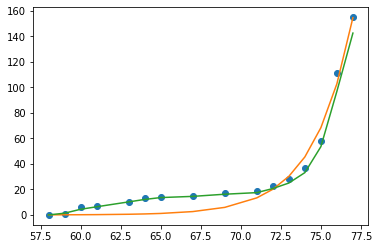

In [39]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [40]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 1374.81020789
Iteration 2, loss = 1373.95719448
Iteration 3, loss = 1373.09854737
Iteration 4, loss = 1372.23669719
Iteration 5, loss = 1371.37144233
Iteration 6, loss = 1370.49439654
Iteration 7, loss = 1369.61374433
Iteration 8, loss = 1368.72876024
Iteration 9, loss = 1367.83020755
Iteration 10, loss = 1366.92173807
Iteration 11, loss = 1366.00500599
Iteration 12, loss = 1365.06117989
Iteration 13, loss = 1364.11149122
Iteration 14, loss = 1363.12777986
Iteration 15, loss = 1362.11786461
Iteration 16, loss = 1361.06683821
Iteration 17, loss = 1359.97019536
Iteration 18, loss = 1358.86310274
Iteration 19, loss = 1357.74496647
Iteration 20, loss = 1356.61145791
Iteration 21, loss = 1355.46503222
Iteration 22, loss = 1354.30862762
Iteration 23, loss = 1353.14198736
Iteration 24, loss = 1351.96498098
Iteration 25, loss = 1350.77746021
Iteration 26, loss = 1349.58023520
Iteration 27, loss = 1348.37336980
Iteration 28, loss = 1347.14518862
Iteration 29, loss = 1345.900

Iteration 455, loss = 326.28101866
Iteration 456, loss = 325.91673465
Iteration 457, loss = 325.55275790
Iteration 458, loss = 325.18918646
Iteration 459, loss = 324.84409269
Iteration 460, loss = 324.47324805
Iteration 461, loss = 324.12000354
Iteration 462, loss = 323.76649917
Iteration 463, loss = 323.41285503
Iteration 464, loss = 323.05918765
Iteration 465, loss = 322.70560885
Iteration 466, loss = 322.35222482
Iteration 467, loss = 321.99913540
Iteration 468, loss = 321.64643350
Iteration 469, loss = 321.29420481
Iteration 470, loss = 320.95661434
Iteration 471, loss = 320.60061563
Iteration 472, loss = 320.25841653
Iteration 473, loss = 319.91603883
Iteration 474, loss = 319.57358958
Iteration 475, loss = 319.23117311
Iteration 476, loss = 318.88889002
Iteration 477, loss = 318.54683626
Iteration 478, loss = 318.20510243
Iteration 479, loss = 317.86525484
Iteration 480, loss = 317.53123186
Iteration 481, loss = 317.19816122
Iteration 482, loss = 316.89342466
Iteration 483, loss 

Iteration 834, loss = 205.28739844
Iteration 835, loss = 204.88973605
Iteration 836, loss = 204.49107597
Iteration 837, loss = 204.09197735
Iteration 838, loss = 203.69142034
Iteration 839, loss = 203.29039129
Iteration 840, loss = 202.88893185
Iteration 841, loss = 202.48707916
Iteration 842, loss = 202.08486628
Iteration 843, loss = 201.68232267
Iteration 844, loss = 201.27947452
Iteration 845, loss = 200.87634518
Iteration 846, loss = 200.47295538
Iteration 847, loss = 200.06932363
Iteration 848, loss = 199.66546638
Iteration 849, loss = 199.26139838
Iteration 850, loss = 198.85713280
Iteration 851, loss = 198.45372510
Iteration 852, loss = 198.04821350
Iteration 853, loss = 197.64356278
Iteration 854, loss = 197.23873975
Iteration 855, loss = 196.83375409
Iteration 856, loss = 196.42861478
Iteration 857, loss = 196.02333023
Iteration 858, loss = 195.61790834
Iteration 859, loss = 195.21235649
Iteration 860, loss = 194.80668168
Iteration 861, loss = 194.40089047
Iteration 862, loss 

Iteration 1106, loss = 98.05129285
Iteration 1107, loss = 97.71932214
Iteration 1108, loss = 97.38812361
Iteration 1109, loss = 97.05766452
Iteration 1110, loss = 96.72791051
Iteration 1111, loss = 96.39882579
Iteration 1112, loss = 96.07037385
Iteration 1113, loss = 95.74251852
Iteration 1114, loss = 95.41522507
Iteration 1115, loss = 95.08846130
Iteration 1116, loss = 94.76219844
Iteration 1117, loss = 94.43641185
Iteration 1118, loss = 94.11108138
Iteration 1119, loss = 93.78619146
Iteration 1120, loss = 93.46173095
Iteration 1121, loss = 93.13769267
Iteration 1122, loss = 92.81407290
Iteration 1123, loss = 92.49087068
Iteration 1124, loss = 92.16808710
Iteration 1125, loss = 91.84572470
Iteration 1126, loss = 91.52378680
Iteration 1127, loss = 91.22864560
Iteration 1128, loss = 90.93050050
Iteration 1129, loss = 90.62669861
Iteration 1130, loss = 90.31826498
Iteration 1131, loss = 90.00613896
Iteration 1132, loss = 89.69117278
Iteration 1133, loss = 89.37413244
Iteration 1134, loss

Iteration 1413, loss = 30.98114762
Iteration 1414, loss = 30.85388322
Iteration 1415, loss = 30.72271246
Iteration 1416, loss = 30.58913914
Iteration 1417, loss = 30.46336471
Iteration 1418, loss = 30.33703550
Iteration 1419, loss = 30.21023278
Iteration 1420, loss = 30.08304769
Iteration 1421, loss = 29.95746911
Iteration 1422, loss = 29.83233877
Iteration 1423, loss = 29.70818794
Iteration 1424, loss = 29.58493324
Iteration 1425, loss = 29.46112773
Iteration 1426, loss = 29.33687172
Iteration 1427, loss = 29.21542359
Iteration 1428, loss = 29.09327464
Iteration 1429, loss = 28.97042254
Iteration 1430, loss = 28.84992415
Iteration 1431, loss = 28.72889199
Iteration 1432, loss = 28.60811243
Iteration 1433, loss = 28.48821548
Iteration 1434, loss = 28.36892904
Iteration 1435, loss = 28.25089575
Iteration 1436, loss = 28.13270238
Iteration 1437, loss = 28.01399265
Iteration 1438, loss = 27.89833732
Iteration 1439, loss = 27.78126778
Iteration 1440, loss = 27.66309767
Iteration 1441, loss

Iteration 1778, loss = 7.65557694
Iteration 1779, loss = 7.62310093
Iteration 1780, loss = 7.59072074
Iteration 1781, loss = 7.55844253
Iteration 1782, loss = 7.52624662
Iteration 1783, loss = 7.49415031
Iteration 1784, loss = 7.46215800
Iteration 1785, loss = 7.43024459
Iteration 1786, loss = 7.39843107
Iteration 1787, loss = 7.36671198
Iteration 1788, loss = 7.33507233
Iteration 1789, loss = 7.30354845
Iteration 1790, loss = 7.27210898
Iteration 1791, loss = 7.24074271
Iteration 1792, loss = 7.20949789
Iteration 1793, loss = 7.17834485
Iteration 1794, loss = 7.14727061
Iteration 1795, loss = 7.11627669
Iteration 1796, loss = 7.08539266
Iteration 1797, loss = 7.05461051
Iteration 1798, loss = 7.02390112
Iteration 1799, loss = 6.99328980
Iteration 1800, loss = 6.96278458
Iteration 1801, loss = 6.93235877
Iteration 1802, loss = 6.90202484
Iteration 1803, loss = 6.87179109
Iteration 1804, loss = 6.84165310
Iteration 1805, loss = 6.81160578
Iteration 1806, loss = 6.78164060
Iteration 1807

Iteration 2104, loss = 2.04265758
Iteration 2105, loss = 2.03612674
Iteration 2106, loss = 2.02958342
Iteration 2107, loss = 2.02304434
Iteration 2108, loss = 2.01650755
Iteration 2109, loss = 2.01024579
Iteration 2110, loss = 2.00383642
Iteration 2111, loss = 1.99732609
Iteration 2112, loss = 1.99103573
Iteration 2113, loss = 1.98472582
Iteration 2114, loss = 1.97868628
Iteration 2115, loss = 1.97306545
Iteration 2116, loss = 1.96739863
Iteration 2117, loss = 1.96170574
Iteration 2118, loss = 1.95600721
Iteration 2119, loss = 1.95027754
Iteration 2120, loss = 1.94455200
Iteration 2121, loss = 1.93895908
Iteration 2122, loss = 1.93324108
Iteration 2123, loss = 1.92759889
Iteration 2124, loss = 1.92197384
Iteration 2125, loss = 1.91637643
Iteration 2126, loss = 1.91072739
Iteration 2127, loss = 1.90520154
Iteration 2128, loss = 1.89964141
Iteration 2129, loss = 1.89413693
Iteration 2130, loss = 1.88857848
Iteration 2131, loss = 1.88309824
Iteration 2132, loss = 1.87790408
Iteration 2133

Iteration 2456, loss = 1.07835601
Iteration 2457, loss = 1.07731401
Iteration 2458, loss = 1.07622508
Iteration 2459, loss = 1.07513322
Iteration 2460, loss = 1.07410055
Iteration 2461, loss = 1.07305549
Iteration 2462, loss = 1.07200274
Iteration 2463, loss = 1.07102467
Iteration 2464, loss = 1.06997026
Iteration 2465, loss = 1.06892686
Iteration 2466, loss = 1.06794969
Iteration 2467, loss = 1.06698042
Iteration 2468, loss = 1.06598368
Iteration 2469, loss = 1.06495622
Iteration 2470, loss = 1.06394534
Iteration 2471, loss = 1.06293405
Iteration 2472, loss = 1.06188606
Iteration 2473, loss = 1.06089091
Iteration 2474, loss = 1.05988980
Iteration 2475, loss = 1.05889921
Iteration 2476, loss = 1.05793256
Iteration 2477, loss = 1.05692691
Iteration 2478, loss = 1.05593504
Iteration 2479, loss = 1.05499037
Iteration 2480, loss = 1.05401660
Iteration 2481, loss = 1.05302433
Iteration 2482, loss = 1.05207422
Iteration 2483, loss = 1.05112734
Iteration 2484, loss = 1.05015049
Iteration 2485

Iteration 2856, loss = 0.79469042
Iteration 2857, loss = 0.79427249
Iteration 2858, loss = 0.79383898
Iteration 2859, loss = 0.79354273
Iteration 2860, loss = 0.79315758
Iteration 2861, loss = 0.79266282
Iteration 2862, loss = 0.79234189
Iteration 2863, loss = 0.79201156
Iteration 2864, loss = 0.79165748
Iteration 2865, loss = 0.79128166
Iteration 2866, loss = 0.79088518
Iteration 2867, loss = 0.79047144
Iteration 2868, loss = 0.79004259
Iteration 2869, loss = 0.78959932
Iteration 2870, loss = 0.78919057
Iteration 2871, loss = 0.78883731
Iteration 2872, loss = 0.78839573
Iteration 2873, loss = 0.78803177
Iteration 2874, loss = 0.78764994
Iteration 2875, loss = 0.78730219
Iteration 2876, loss = 0.78688658
Iteration 2877, loss = 0.78650207
Iteration 2878, loss = 0.78610791
Iteration 2879, loss = 0.78575304
Iteration 2880, loss = 0.78538360
Iteration 2881, loss = 0.78498985
Iteration 2882, loss = 0.78459586
Iteration 2883, loss = 0.78427722
Iteration 2884, loss = 0.78390082
Iteration 2885

Iteration 3249, loss = 0.67884591
Iteration 3250, loss = 0.67864770
Iteration 3251, loss = 0.67842459
Iteration 3252, loss = 0.67823527
Iteration 3253, loss = 0.67804029
Iteration 3254, loss = 0.67782393
Iteration 3255, loss = 0.67759991
Iteration 3256, loss = 0.67739131
Iteration 3257, loss = 0.67719124
Iteration 3258, loss = 0.67696668
Iteration 3259, loss = 0.67677753
Iteration 3260, loss = 0.67657659
Iteration 3261, loss = 0.67637053
Iteration 3262, loss = 0.67615328
Iteration 3263, loss = 0.67594968
Iteration 3264, loss = 0.67575105
Iteration 3265, loss = 0.67552628
Iteration 3266, loss = 0.67534149
Iteration 3267, loss = 0.67514893
Iteration 3268, loss = 0.67494607
Iteration 3269, loss = 0.67473009
Iteration 3270, loss = 0.67450304
Iteration 3271, loss = 0.67433040
Iteration 3272, loss = 0.67414444
Iteration 3273, loss = 0.67393569
Iteration 3274, loss = 0.67370590
Iteration 3275, loss = 0.67350889
Iteration 3276, loss = 0.67333800
Iteration 3277, loss = 0.67313074
Iteration 3278

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  0.41137997,   2.43040698,   4.449434  ,   6.46846101,
        10.50651505,  12.52554206,  13.49000449,  15.41282045,
        17.31482333,  19.1776025 ,  23.30710783,  27.43661316,
        37.07972453,  59.44562937, 107.99776496, 156.54990055])

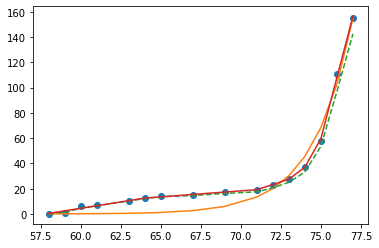

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [43]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([20355.35552838])